### <center>Zadanie 5</center>

#### Klasyfikacja na zbiorze dotyczącym stopnii otyłości

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, LearningCurveDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from IPython.display import display
from sklearn.model_selection import GridSearchCV

### <center>Wczytanie i zapoznanie się z danymi</center>

In [2]:
obesity = pd.read_csv('ObesityDataSet.csv')

obesity.drop(columns=['Weight'], inplace=True)
obesity['CALC'] = obesity['CALC'].apply(lambda row: 'Frequently' if row == 'Always' else row)
obesity['MTRANS'] = obesity['MTRANS'].apply(lambda row: 'Motorbike' if row == 'Bike' else row)

obesity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   family_history_with_overweight  2111 non-null   object 
 4   FAVC                            2111 non-null   object 
 5   FCVC                            2111 non-null   float64
 6   NCP                             2111 non-null   float64
 7   CAEC                            2111 non-null   object 
 8   SMOKE                           2111 non-null   object 
 9   CH2O                            2111 non-null   float64
 10  SCC                             2111 non-null   object 
 11  FAF                             2111 non-null   float64
 12  TUE                             21

In [3]:
obesity.head()

,Gender,Age,Height,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


#### <center>Opis kolumn</center>

<table>
    <tr>
        <th>Nazwa kolumny</th>
        <th>Opis</th>
        <th>Wartości</th>
    </tr>
    <tr>
        <td>Gender</td>
        <td>Płeć</td>
        <td>(Female/Male)</td>
    </tr>
    <tr>
        <td>Age</td>
        <td>Wiek pacjenta</td>
        <td>Zmienna numeryczna</td>
    </tr>
    <tr>
        <td>Height</td>
        <td>Wzrost pacjenta</td>
        <td>Zmienna numeryczna</td>
    </tr>
    <tr>
        <td>Weight</td>
        <td>Waga pacjenta</td>
        <td>Zmienna numeryczna</td>
    </tr>
    <tr>
        <td>family_history_with_overweight</td>
        <td>Historia problemów z wagą w rodzinie</td>
        <td>yes/no</td>
    </tr>
    <tr>
        <td>FAVC</td>
        <td>Częste spożywanie wysokokalorycznych posiłków</td>
        <td>yes/no</td>
    </tr>
    <tr>
        <td>FCVC</td>
        <td>Częstotliwość spożycia warzyw</td>
        <td>Zmienna numeryczna</td>
    </tr>
    <tr>
        <td>NCP</td>
        <td>Ilość głównych posiłków</td>
        <td>Zmienna numeryczna</td>
    </tr>
    <tr>
        <td>CAEC</td>
        <td>Spożycie przekąsek między posiłkami</td>
        <td>Sometimes/Frequently/Always/no</td>
    </tr>
    <tr>
        <td>SMOKE</td>
        <td>Palenie papierosów</td>
        <td>yes/no</td>
    </tr>
    <tr>
        <td>CH2O</td>
        <td>Spożycie wody</td>
        <td>Zmienna numeryczna</td>
    </tr>
    <tr>
        <td>SCC</td>
        <td>Śledzenie ilości spożytych kalorii</td>
        <td>yes/no</td>
    </tr>
    <tr>
        <td>FAF</td>
        <td>Częstotliwość aktywności fizycznej</td>
        <td>Zmienna numeryczna</td>
    </tr>
    <tr>
        <td>TUE</td>
        <td>Czas poświęcony na korzystanie z urządzeń elektronicznych</td>
        <td>Zmienna numeryczna</td>
    </tr>
    <tr>
        <td>CALC</td>
        <td>Spożycie alkoholu</td>
        <td>Sometimes/Frequently/Always/no</td>
    </tr>
    <tr>
        <td>MTRANS</td>
        <td>Wykorzystywany środek transportu</td>
        <td>Public_Transportation/Automobile/Walking/Motorbike/Bike</td>
    </tr>
    <tr>
        <td>NObeyesdad</td>
        <td>Kategoria wagowa</td>
        <td>7 klas</td>
    </tr>
</table>


#### <center>Wykresy kołowe dla zmiennych kategorycznych</center>

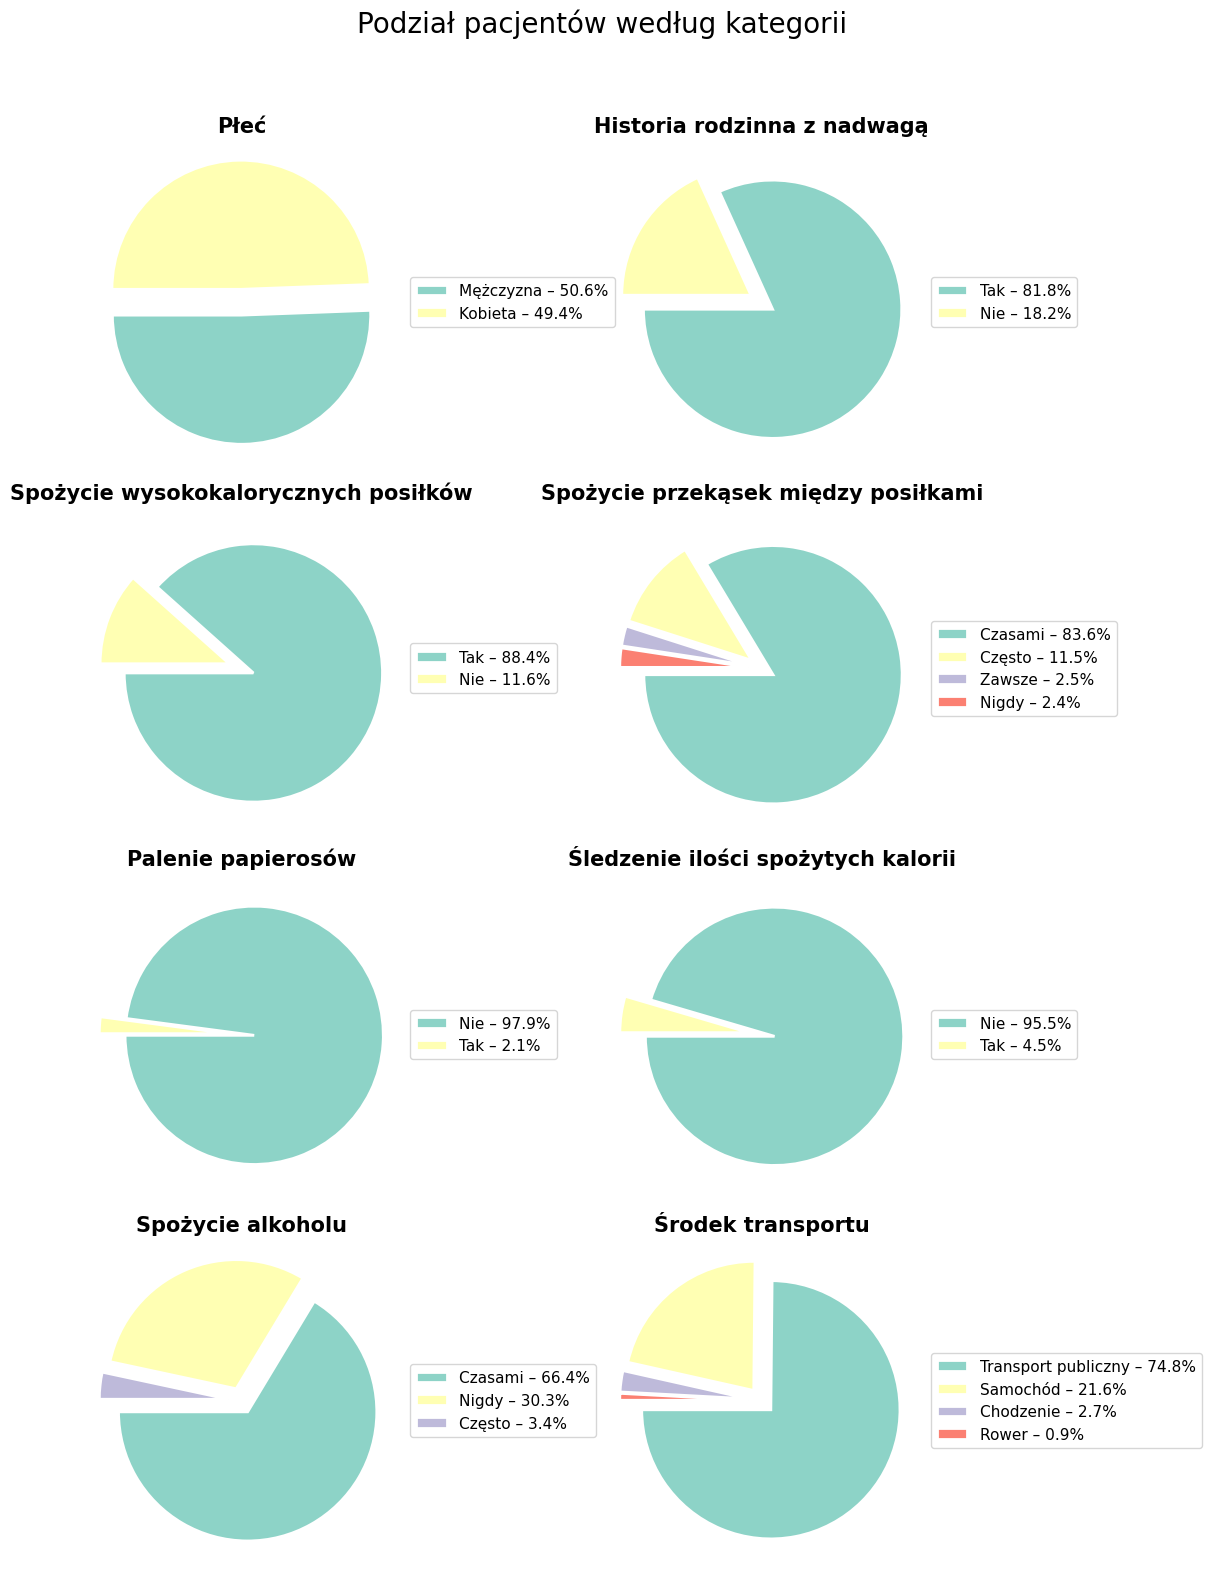

In [4]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12, 16))
plt.suptitle('Podział pacjentów według kategorii', fontsize=20)

colors = plt.cm.Set3.colors
title_mapping = {
    'Gender': 'Płeć',
    'family_history_with_overweight': 'Historia rodzinna z nadwagą',
    'FAVC': 'Spożycie wysokokalorycznych posiłków',
    'CAEC': 'Spożycie przekąsek między posiłkami',
    'SMOKE': 'Palenie papierosów',
    'SCC': 'Śledzenie ilości spożytych kalorii',
    'CALC': 'Spożycie alkoholu',
    'MTRANS': 'Środek transportu'
}
object_columns = obesity.select_dtypes(include=['object']).columns[:-1]

for i, column in enumerate(object_columns):
    x, y = divmod(i, 2)
    el = obesity[column].value_counts()
    explode = [0.1 for _ in range(len(el))]

    if column == 'Gender':
        label_mapping = {'Female': 'Kobieta', 'Male': 'Mężczyzna'}
    elif column in ['CALC', 'CAEC']:
        label_mapping = {
            'Sometimes': 'Czasami',
            'no': 'Nigdy',
            'Frequently': 'Często',
            'Always':'Zawsze'
        }
    elif column == 'MTRANS':
        label_mapping = {
            'Public_Transportation': 'Transport publiczny',
            'Automobile': 'Samochód',
            'Motorbike': 'Rower',
            'Walking': 'Chodzenie'
        }
    else:
        label_mapping = {'yes': 'Tak', 'no': 'Nie'}

    total = el.sum()
    labels_with_pct = [
        f'{label_mapping.get(k)} – {round((v / total) * 100, 1)}%'
        for k, v in el.items()
    ]

    ax[x, y].pie(
        x=el,
        explode=explode,
        labels=None,
        colors=colors,
        radius=1,
        startangle=180,
        wedgeprops={'edgecolor': 'white', 'linewidth': 2},
        normalize=True,
    )

    ax[x, y].legend(
        labels_with_pct,
        loc='center left',
        bbox_to_anchor=(1, 0.5),
        fontsize=11
    )
    ax[x, y].set_title(title_mapping.get(column), fontsize=15, fontweight='bold')

ax[3, 1].axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Kodowanie one-hot kategorii

In [5]:
many_categories = [col for col in object_columns if col != 'NObeyesdad']
obesity = pd.get_dummies(obesity, columns=many_categories, drop_first=True)

obesity_encoder = LabelEncoder().fit(obesity['NObeyesdad'])
obesity_status = obesity['NObeyesdad']
obesity_status = obesity_encoder.transform(obesity_status)
obesity['NObeyesdad'] = obesity_status

obesity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 21 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 2111 non-null   float64
 1   Height                              2111 non-null   float64
 2   FCVC                                2111 non-null   float64
 3   NCP                                 2111 non-null   float64
 4   CH2O                                2111 non-null   float64
 5   FAF                                 2111 non-null   float64
 6   TUE                                 2111 non-null   float64
 7   NObeyesdad                          2111 non-null   int64  
 8   Gender_Male                         2111 non-null   bool   
 9   family_history_with_overweight_yes  2111 non-null   bool   
 10  FAVC_yes                            2111 non-null   bool   
 11  CAEC_Frequently                     2111 no

#### <center>Histogramy dla danych numerycznych</center>

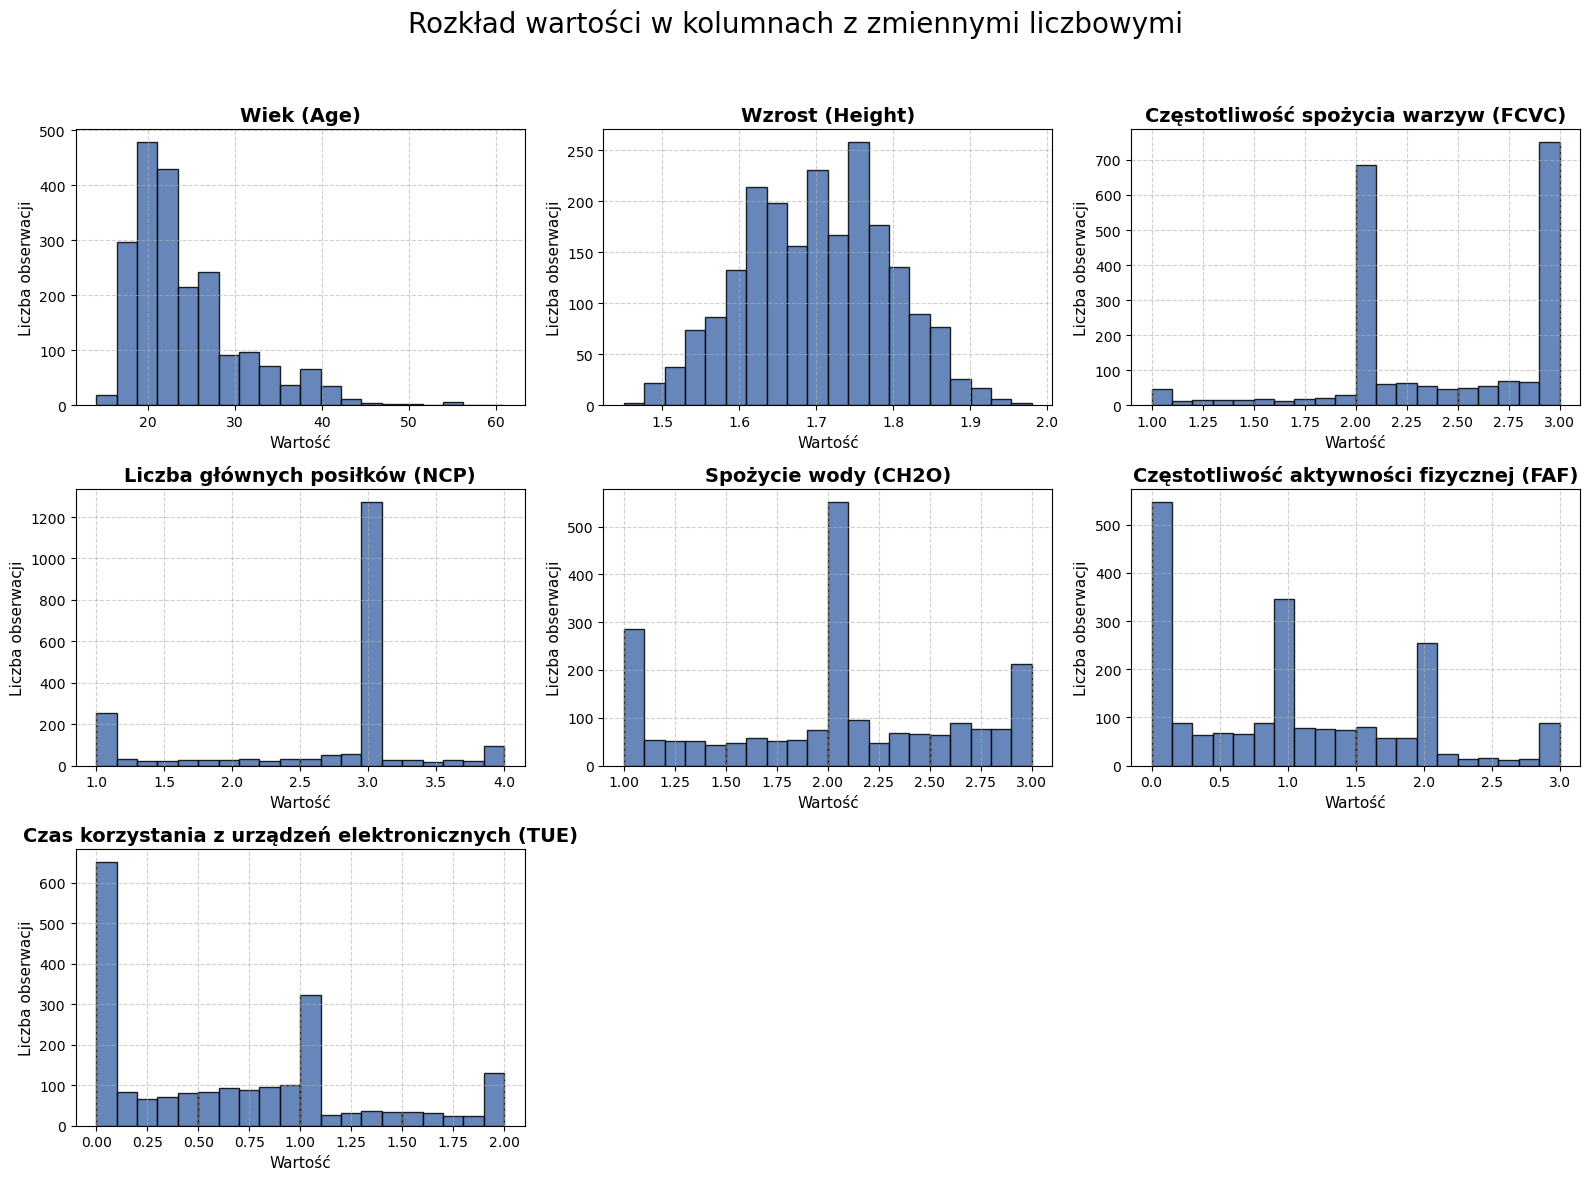

In [6]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))
plt.suptitle('Rozkład wartości w kolumnach z zmiennymi liczbowymi', fontsize=20)

numeric_columns = obesity.select_dtypes(include=np.float64).columns

title_mapping = {
    'Age': 'Wiek',
    'Height': 'Wzrost',
    'Weight': 'Waga',
    'FCVC': 'Częstotliwość spożycia warzyw',
    'NCP': 'Liczba głównych posiłków',
    'CH2O': 'Spożycie wody',
    'FAF': 'Częstotliwość aktywności fizycznej',
    'TUE': 'Czas korzystania z urządzeń elektronicznych'
}

for i, column in enumerate(numeric_columns):
    x, y = divmod(i, 3)
    ax[x, y].hist(
        obesity[column],
        bins=20,
        color='#4C72B0',
        edgecolor='black',
        alpha=0.85
    )

    ax[x, y].set_title(f'{title_mapping.get(column)} ({column})', fontsize=14, fontweight='bold')
    ax[x, y].set_xlabel('Wartość', fontsize=11)
    ax[x, y].set_ylabel('Liczba obserwacji', fontsize=11)
    ax[x, y].grid(True, linestyle='--', alpha=0.6)

ax[2, 1].axis('off')
ax[2, 2].axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### <center>Macierz korelacji</center>

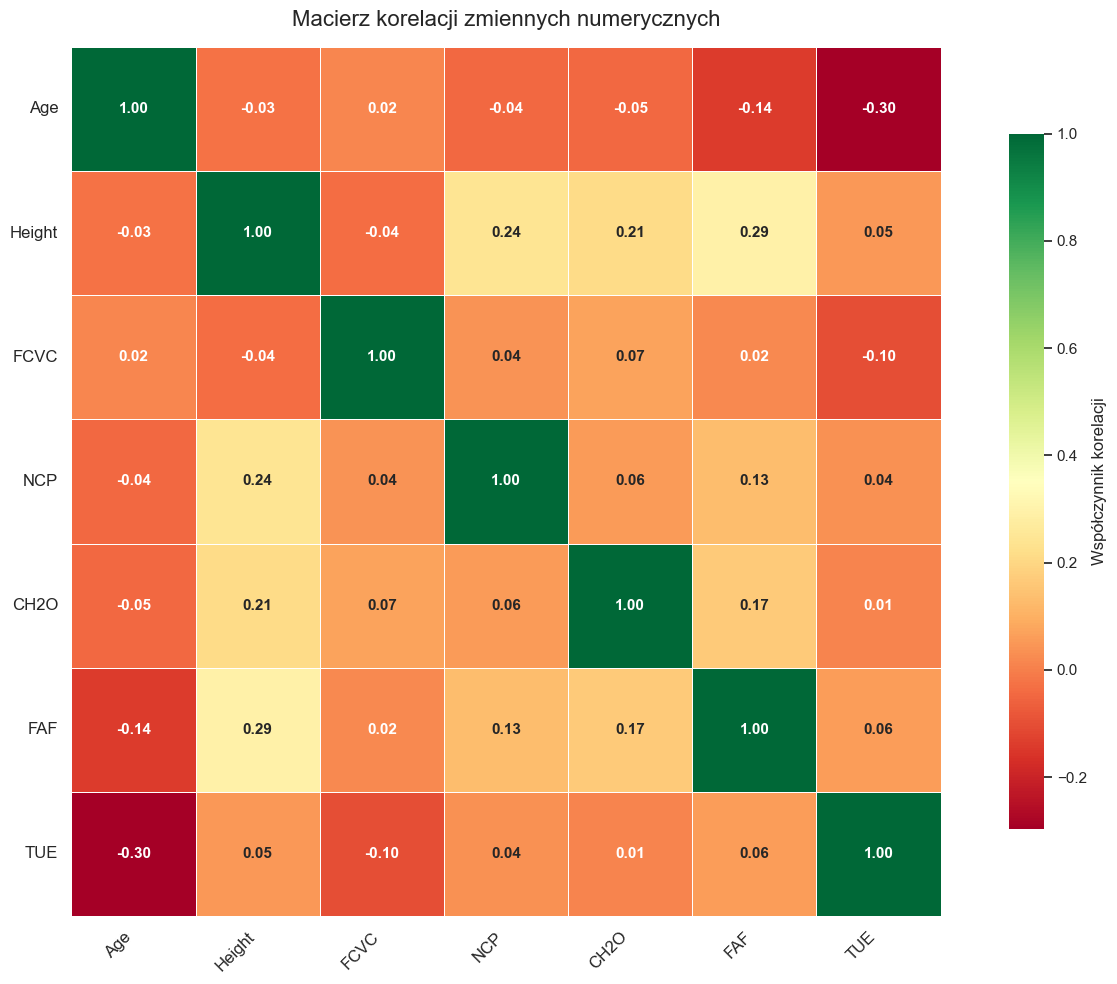

In [7]:
plt.figure(figsize=(14, 10))
sns.set_theme(style='whitegrid')

corr = obesity.select_dtypes(include=[np.float64, np.int32]).corr()

sns.heatmap(
    corr,
    cmap='RdYlGn',
    annot=True,
    fmt='.2f',
    linewidths=0.5,
    linecolor='white',
    annot_kws={'fontsize': 11, 'fontweight': 'bold'},
    square=True,
    cbar_kws={'shrink': 0.8, 'label': 'Współczynnik korelacji'}
)

plt.title('Macierz korelacji zmiennych numerycznych', fontsize=16, pad=15)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()

### <center>Klasyfikacja przy wykorzystaniu KNN, drzewa decyzyjnego i lasu</center>

In [8]:
X = obesity.drop(columns='NObeyesdad')
y = obesity_status

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

X.head()

,Age,Height,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,family_history_with_overweight_yes,FAVC_yes,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_yes,SCC_yes,CALC_Sometimes,CALC_no,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,21.0,1.62,2.0,3.0,2.0,0.0,1.0,False,True,False,False,True,False,False,False,False,True,False,True,False
1,21.0,1.52,3.0,3.0,3.0,3.0,0.0,False,True,False,False,True,False,True,True,True,False,False,True,False
2,23.0,1.80,2.0,3.0,2.0,2.0,1.0,True,True,False,False,True,False,False,False,False,False,False,True,False
3,27.0,1.80,3.0,3.0,2.0,2.0,0.0,True,False,False,False,True,False,False,False,False,False,False,False,True
4,22.0,1.78,2.0,1.0,2.0,0.0,0.0,True,False,False,False,True,False,False,False,True,False,False,True,False


#### <center>Szukanie optymalnych hiperparametrów</center>

Optuna to framework służący do poszukiwania optymalnych hiperparametrów. W odróżnieniu od GridSearchCV nie przeszukuje wszystkich możliwych kombinacji parametrów aby odnaleźć najbardziej optymalne. Wykorzystuje strategie optymalizacji opartej na dedykowanych algorytmach, tzw. samplerach.

In [9]:
def define_knn(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 20),
        'weights': trial.suggest_categorical('weights', ['uniform','distance']),
    }


    scaler_only_numeric = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_columns)
        ],
        remainder='passthrough'
    )
    return Pipeline([('scaler_only_numeric', scaler_only_numeric), ('knn', KNeighborsClassifier(**params))])

def objective_knn(trial):
    knn = define_knn(trial)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(knn, X_train, y_train, cv=skf, n_jobs=-1, scoring='accuracy')
    return scores.mean()

search_space = {
        'n_neighbors': list(range(3, 21)),
        'weights': ['uniform','distance'],
}
study_knn = optuna.create_study(study_name='ObesityKNN', sampler=optuna.samplers.GridSampler(search_space=search_space),direction='maximize')
study_knn.optimize(objective_knn)


[I 2025-04-15 11:22:22,678] A new study created in memory with name: ObesityKNN
[I 2025-04-15 11:22:24,721] Trial 0 finished with value: 0.7982134677049931 and parameters: {'n_neighbors': 4, 'weights': 'distance'}. Best is trial 0 with value: 0.7982134677049931.
[I 2025-04-15 11:22:25,267] Trial 1 finished with value: 0.6621232249198351 and parameters: {'n_neighbors': 16, 'weights': 'uniform'}. Best is trial 0 with value: 0.7982134677049931.
[I 2025-04-15 11:22:25,300] Trial 2 finished with value: 0.6512940907008704 and parameters: {'n_neighbors': 19, 'weights': 'uniform'}. Best is trial 0 with value: 0.7982134677049931.
[I 2025-04-15 11:22:25,320] Trial 3 finished with value: 0.6932615666513972 and parameters: {'n_neighbors': 11, 'weights': 'uniform'}. Best is trial 0 with value: 0.7982134677049931.
[I 2025-04-15 11:22:25,339] Trial 4 finished with value: 0.7636875858909757 and parameters: {'n_neighbors': 5, 'weights': 'uniform'}. Best is trial 0 with value: 0.7982134677049931.
[I 202

In [10]:
def define_decision_tree(trial):
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 20),
    }
    return DecisionTreeClassifier(**params)

def objective_decision_tree(trial):
    dc = define_decision_tree(trial)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(dc, X_train, y_train, cv=skf, n_jobs=-1, scoring='accuracy')
    return scores.mean()

study_dc = optuna.create_study(direction='maximize', study_name='ObesityDecisionTree', sampler=optuna.samplers.TPESampler())
study_dc.optimize(objective_decision_tree, n_trials=100)

[I 2025-04-15 11:22:25,959] A new study created in memory with name: ObesityDecisionTree
[I 2025-04-15 11:22:25,988] Trial 0 finished with value: 0.7115758131012369 and parameters: {'criterion': 'entropy', 'max_depth': 19, 'min_samples_split': 14, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7115758131012369.
[I 2025-04-15 11:22:26,007] Trial 1 finished with value: 0.628289051763628 and parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.7115758131012369.
[I 2025-04-15 11:22:26,028] Trial 2 finished with value: 0.619502977553825 and parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 13, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.7115758131012369.
[I 2025-04-15 11:22:26,045] Trial 3 finished with value: 0.5984974805313789 and parameters: {'criterion': 'gini', 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.711575813101236

In [11]:
def define_random_forest(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 20),
        'max_features': trial.suggest_int('max_features', 2, len(X_train.columns)),
        'n_jobs': -1
    }
    return RandomForestClassifier(**params)

def objective_random_forest(trial):
    rf = define_random_forest(trial)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(rf, X_train, y_train, cv=skf, n_jobs=-1, scoring='accuracy')
    return scores.mean()

study_rf = optuna.create_study(direction='maximize', study_name='ObesityRandomForest', sampler=optuna.samplers.TPESampler())
study_rf.optimize(objective_random_forest, n_trials=100)

[I 2025-04-15 11:22:28,577] A new study created in memory with name: ObesityRandomForest
[I 2025-04-15 11:22:28,814] Trial 0 finished with value: 0.805698579935868 and parameters: {'n_estimators': 84, 'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 12}. Best is trial 0 with value: 0.805698579935868.
[I 2025-04-15 11:22:28,909] Trial 1 finished with value: 0.7468231791113147 and parameters: {'n_estimators': 48, 'criterion': 'gini', 'max_depth': 17, 'min_samples_split': 18, 'min_samples_leaf': 14, 'max_features': 4}. Best is trial 0 with value: 0.805698579935868.
[I 2025-04-15 11:22:29,099] Trial 2 finished with value: 0.7982661475034357 and parameters: {'n_estimators': 94, 'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 11}. Best is trial 0 with value: 0.805698579935868.
[I 2025-04-15 11:22:29,366] Trial 3 finished with value: 0.7258016491067338 and parameters: {'n_estimators': 

### <center>Najlepsze modele</center>

#### <center>1. KNN</center>

KNN (K-Nearest Neighbors) to prosty algorytm, który w klasyfikacji przypisuje etykietę na podstawie K najbliższych sąsiadów w przestrzeni cech. Nie buduje modelu w trakcie uczenia – decyzja zapada dopiero podczas predykcji na podstawie odległości (np. euklidesowej) między punktami.

In [12]:

best_params = study_knn.best_params

accuracy = study_knn.best_value
best_params_with_acc = best_params.copy()
best_params_with_acc['Dokładność (CV)'] = f"{accuracy:.3f}"


params_df = pd.DataFrame.from_dict(best_params_with_acc, orient='index', columns=['Wartość'])
params_df.index.name = 'Hiperparametr / Metryka'


styled_df = (
    params_df.style
    .set_caption("Najlepsze hiperparametry KNN z wynikiem walidacji krzyżowej")
    .set_table_styles([
        {'selector': 'caption', 'props': [('text-align', 'center'), ('font-size', '18px'), ('font-weight', 'bold')]},
        {'selector': 'th', 'props': [('font-size', '14px'), ('padding', '10px')]},
        {'selector': 'td', 'props': [('font-size', '14px'), ('padding', '10px')]}
    ])
)

display(styled_df)


,Wartość
Hiperparametr / Metryka,
n_neighbors,4
weights,distance
Dokładność (CV),0.798


In [13]:
knn_pipeline = define_knn(study_knn.best_trial)
knn_pipeline.fit(X_train, y_train)

class_labels = np.unique(y)
bknn_pred = knn_pipeline.predict(X_test)

print(classification_report(y_true=y_test, y_pred=bknn_pred, labels=class_labels, target_names=obesity_encoder.inverse_transform(class_labels)))

                     precision    recall  f1-score   support

Insufficient_Weight       0.80      0.90      0.85        82
      Normal_Weight       0.75      0.35      0.48        86
     Obesity_Type_I       0.75      0.89      0.81       106
    Obesity_Type_II       0.83      0.92      0.87        89
   Obesity_Type_III       0.92      0.99      0.96        97
 Overweight_Level_I       0.71      0.72      0.72        87
Overweight_Level_II       0.79      0.76      0.77        87

           accuracy                           0.80       634
          macro avg       0.79      0.79      0.78       634
       weighted avg       0.79      0.80      0.78       634



#### <center>2. Drzewo decyzyjne</center>

Drzewo decyzyjne to algorytm uczenia maszynowego, który posiada hierarchiczną strukturę, w której:

- węzły decyzyjne reprezentują warunki podziału danych na podstawie wartości określonych cech (atrybutów)
- gałęzie odpowiadają wynikom tych warunków
- liście zawierają końcowe przewidywania modelu

In [14]:

best_params = study_dc.best_params

accuracy = study_dc.best_value
best_params_with_acc = best_params.copy()
best_params_with_acc['Dokładność (CV)'] = f"{accuracy:.3f}"


params_df = pd.DataFrame.from_dict(best_params_with_acc, orient='index', columns=['Wartość'])
params_df.index.name = 'Hiperparametr / Metryka'


styled_df = (
    params_df.style
    .set_caption("Najlepsze hiperparametry drzewa decyzyjnego z wynikiem walidacji krzyżowej")
    .set_table_styles([
        {'selector': 'caption', 'props': [('text-align', 'center'), ('font-size', '18px'), ('font-weight', 'bold')]},
        {'selector': 'th', 'props': [('font-size', '14px'), ('padding', '10px')]},
        {'selector': 'td', 'props': [('font-size', '14px'), ('padding', '10px')]}
    ])
)

display(styled_df)


,Wartość
Hiperparametr / Metryka,
criterion,entropy
max_depth,16
min_samples_split,2
min_samples_leaf,2
Dokładność (CV),0.760


In [15]:
bdc = define_decision_tree(study_dc.best_trial)
bdc.fit(X_train, y_train)
bdc_pred = bdc.predict(X_test)

print(classification_report(y_true=y_test, y_pred=bdc_pred, labels=class_labels, target_names=obesity_encoder.inverse_transform(class_labels)))

                     precision    recall  f1-score   support

Insufficient_Weight       0.74      0.77      0.75        82
      Normal_Weight       0.53      0.64      0.58        86
     Obesity_Type_I       0.85      0.83      0.84       106
    Obesity_Type_II       0.91      0.90      0.90        89
   Obesity_Type_III       0.98      0.99      0.98        97
 Overweight_Level_I       0.73      0.70      0.71        87
Overweight_Level_II       0.79      0.64      0.71        87

           accuracy                           0.79       634
          macro avg       0.79      0.78      0.78       634
       weighted avg       0.79      0.79      0.79       634



#### <center>Istotność cech dla drzewa decyzyjnego</center>

Ta metoda mierzy ważność cech na podstawie ich wpływu na zmniejszenie nieczystości (impurity) podczas budowy drzewa decyzyjnego.

#### Jak to działa?
- Podczas tworzenia drzewa, algorytm wybiera te cechy, które najlepiej zmniejszają impurity (np. Gini lub entropię), co prowadzi do lepszego rozdzielenia klas.
- Dla każdej cechy oblicza się sumę redukcji nieczystości we wszystkich węzłach, gdzie ta cecha była użyta do podziału.
- Te wartości są następnie *umowane i normalizowane, tak aby suma ważności wszystkich cech wynosiła 1.

####  Interpretacja
- Im wyższa wartość ważności, tym większy wpływ danej cechy na podziały w drzewie, a więc większa jej rola w modelu.


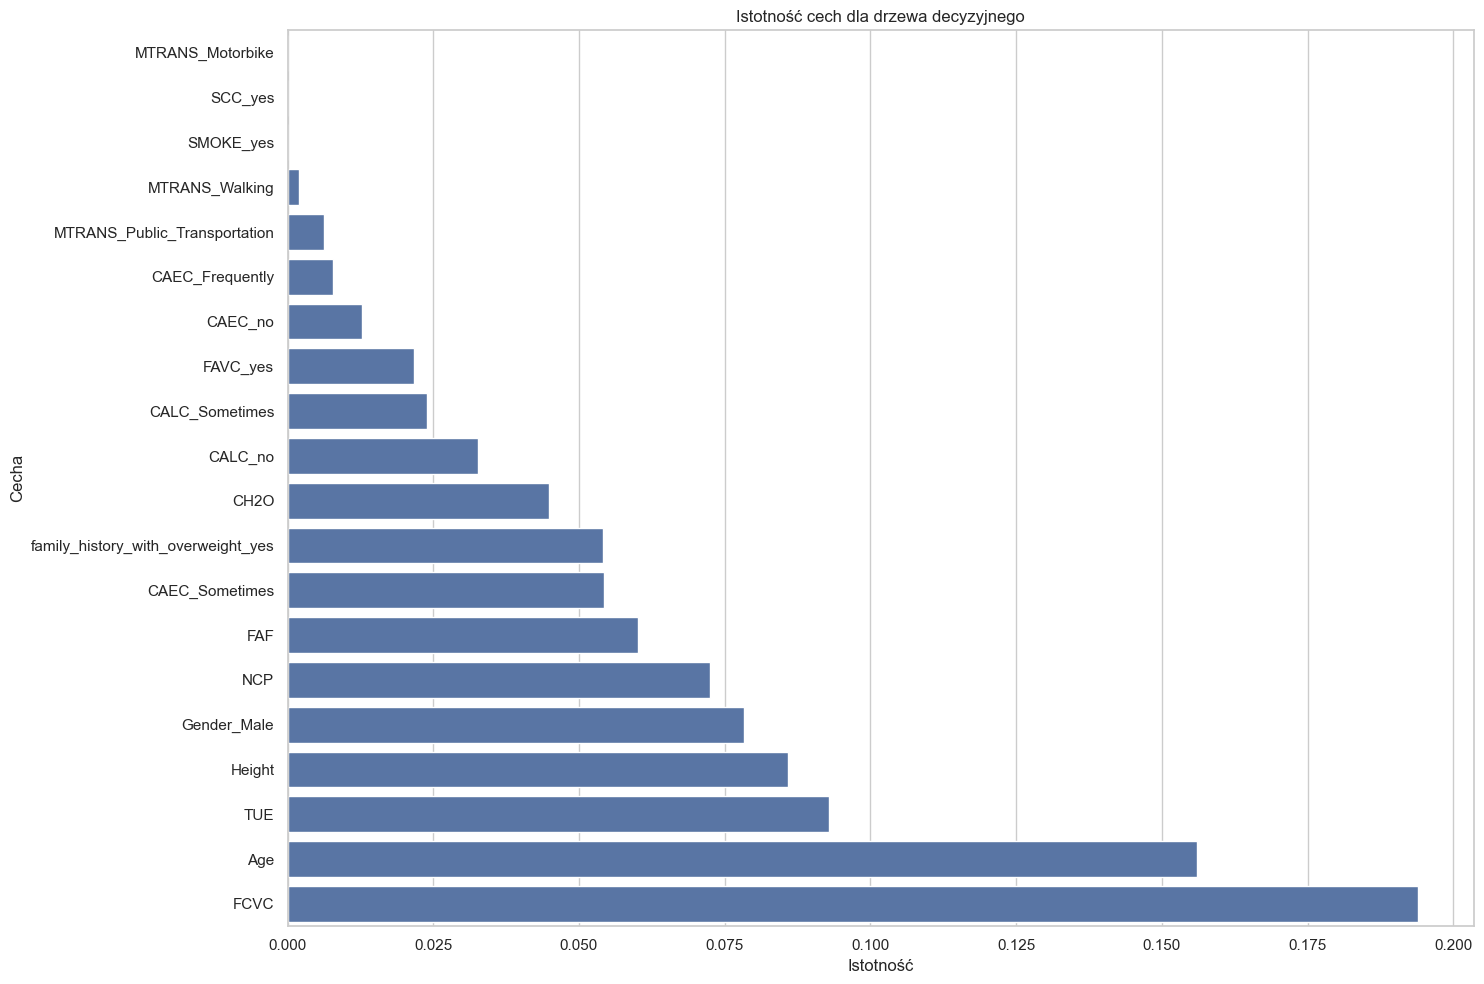

In [16]:
dc_feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': bdc.feature_importances_
}).sort_values(by='importance', ascending=True)

plt.figure(figsize=(15, 10))
sns.barplot(data=dc_feature_importance, x='importance', y='feature')

plt.title('Istotność cech dla drzewa decyzyjnego')
plt.xlabel('Istotność')
plt.ylabel('Cecha')
plt.tight_layout()
plt.show()

#### <center>3. Las losowy</center>

Las losowy to algorytm, który jest zbudowany z wielu drzew decyzyjnych. Każde z nich jest trenowane na innej losowej próbce danych treningowych. Wynik w klasyfikacji dla lasu jest osiągany przez głosowanie większościowe - wybierana jest klasa najczęściej wskazywana przez poszczególne drzewa. Jest bardziej odporny na przeuczenie niż pojedyńcze drzewo decyzyjne.

In [17]:

best_params = study_rf.best_params

accuracy = study_rf.best_value
best_params_with_acc = best_params.copy()
best_params_with_acc['Dokładność (CV)'] = f"{accuracy:.3f}"


params_df = pd.DataFrame.from_dict(best_params_with_acc, orient='index', columns=['Wartość'])
params_df.index.name = 'Hiperparametr / Metryka'


styled_df = (
    params_df.style
    .set_caption("Najlepsze hiperparametry lasu losowego z wynikiem walidacji krzyżowej")
    .set_table_styles([
        {'selector': 'caption', 'props': [('text-align', 'center'), ('font-size', '18px'), ('font-weight', 'bold')]},
        {'selector': 'th', 'props': [('font-size', '14px'), ('padding', '10px')]},
        {'selector': 'td', 'props': [('font-size', '14px'), ('padding', '10px')]}
    ])
)

display(styled_df)


,Wartość
Hiperparametr / Metryka,
n_estimators,68
criterion,gini
max_depth,18
min_samples_split,3
min_samples_leaf,2
max_features,6
Dokładność (CV),0.859


In [18]:
brf = define_random_forest(study_rf.best_trial)
brf.fit(X_train, y_train)
brf_pred = brf.predict(X_test)

print(classification_report(y_true=y_test, y_pred=brf_pred, labels=class_labels, target_names=obesity_encoder.inverse_transform(class_labels)))

                     precision    recall  f1-score   support

Insufficient_Weight       0.95      0.87      0.90        82
      Normal_Weight       0.61      0.76      0.68        86
     Obesity_Type_I       0.82      0.88      0.85       106
    Obesity_Type_II       0.95      0.93      0.94        89
   Obesity_Type_III       0.99      0.99      0.99        97
 Overweight_Level_I       0.81      0.75      0.78        87
Overweight_Level_II       0.84      0.74      0.79        87

           accuracy                           0.85       634
          macro avg       0.85      0.84      0.85       634
       weighted avg       0.86      0.85      0.85       634



#### <center>Istotność cech dla lasu losowego</center>

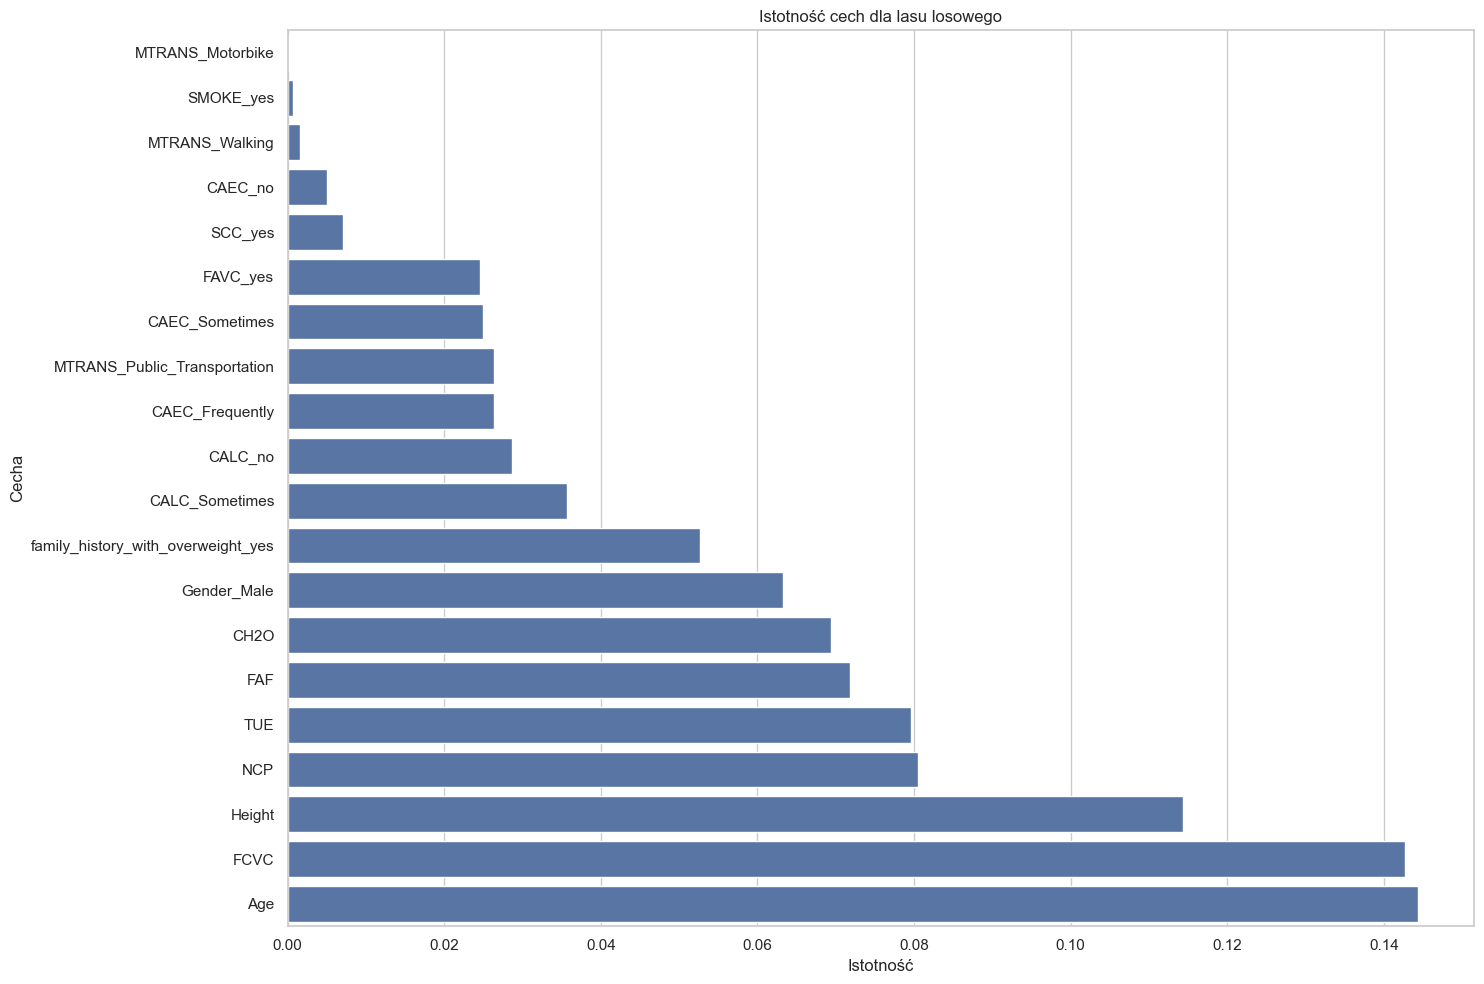

In [19]:
rf_feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': brf.feature_importances_
}).sort_values(by='importance', ascending=True)

plt.figure(figsize=(15, 10))
sns.barplot(data=rf_feature_importance, x='importance', y='feature')

plt.title('Istotność cech dla lasu losowego')
plt.xlabel('Istotność')
plt.ylabel('Cecha')
plt.tight_layout()

plt.show()

#### <center>Macierze pomyłek</center>

Macierz pomyłek (błędów, ang. confusion matrix) prezentuje liczby przypadków należących do poszczególnych poprawnych klas decyzyjnych oraz tych, które są przewidywane.

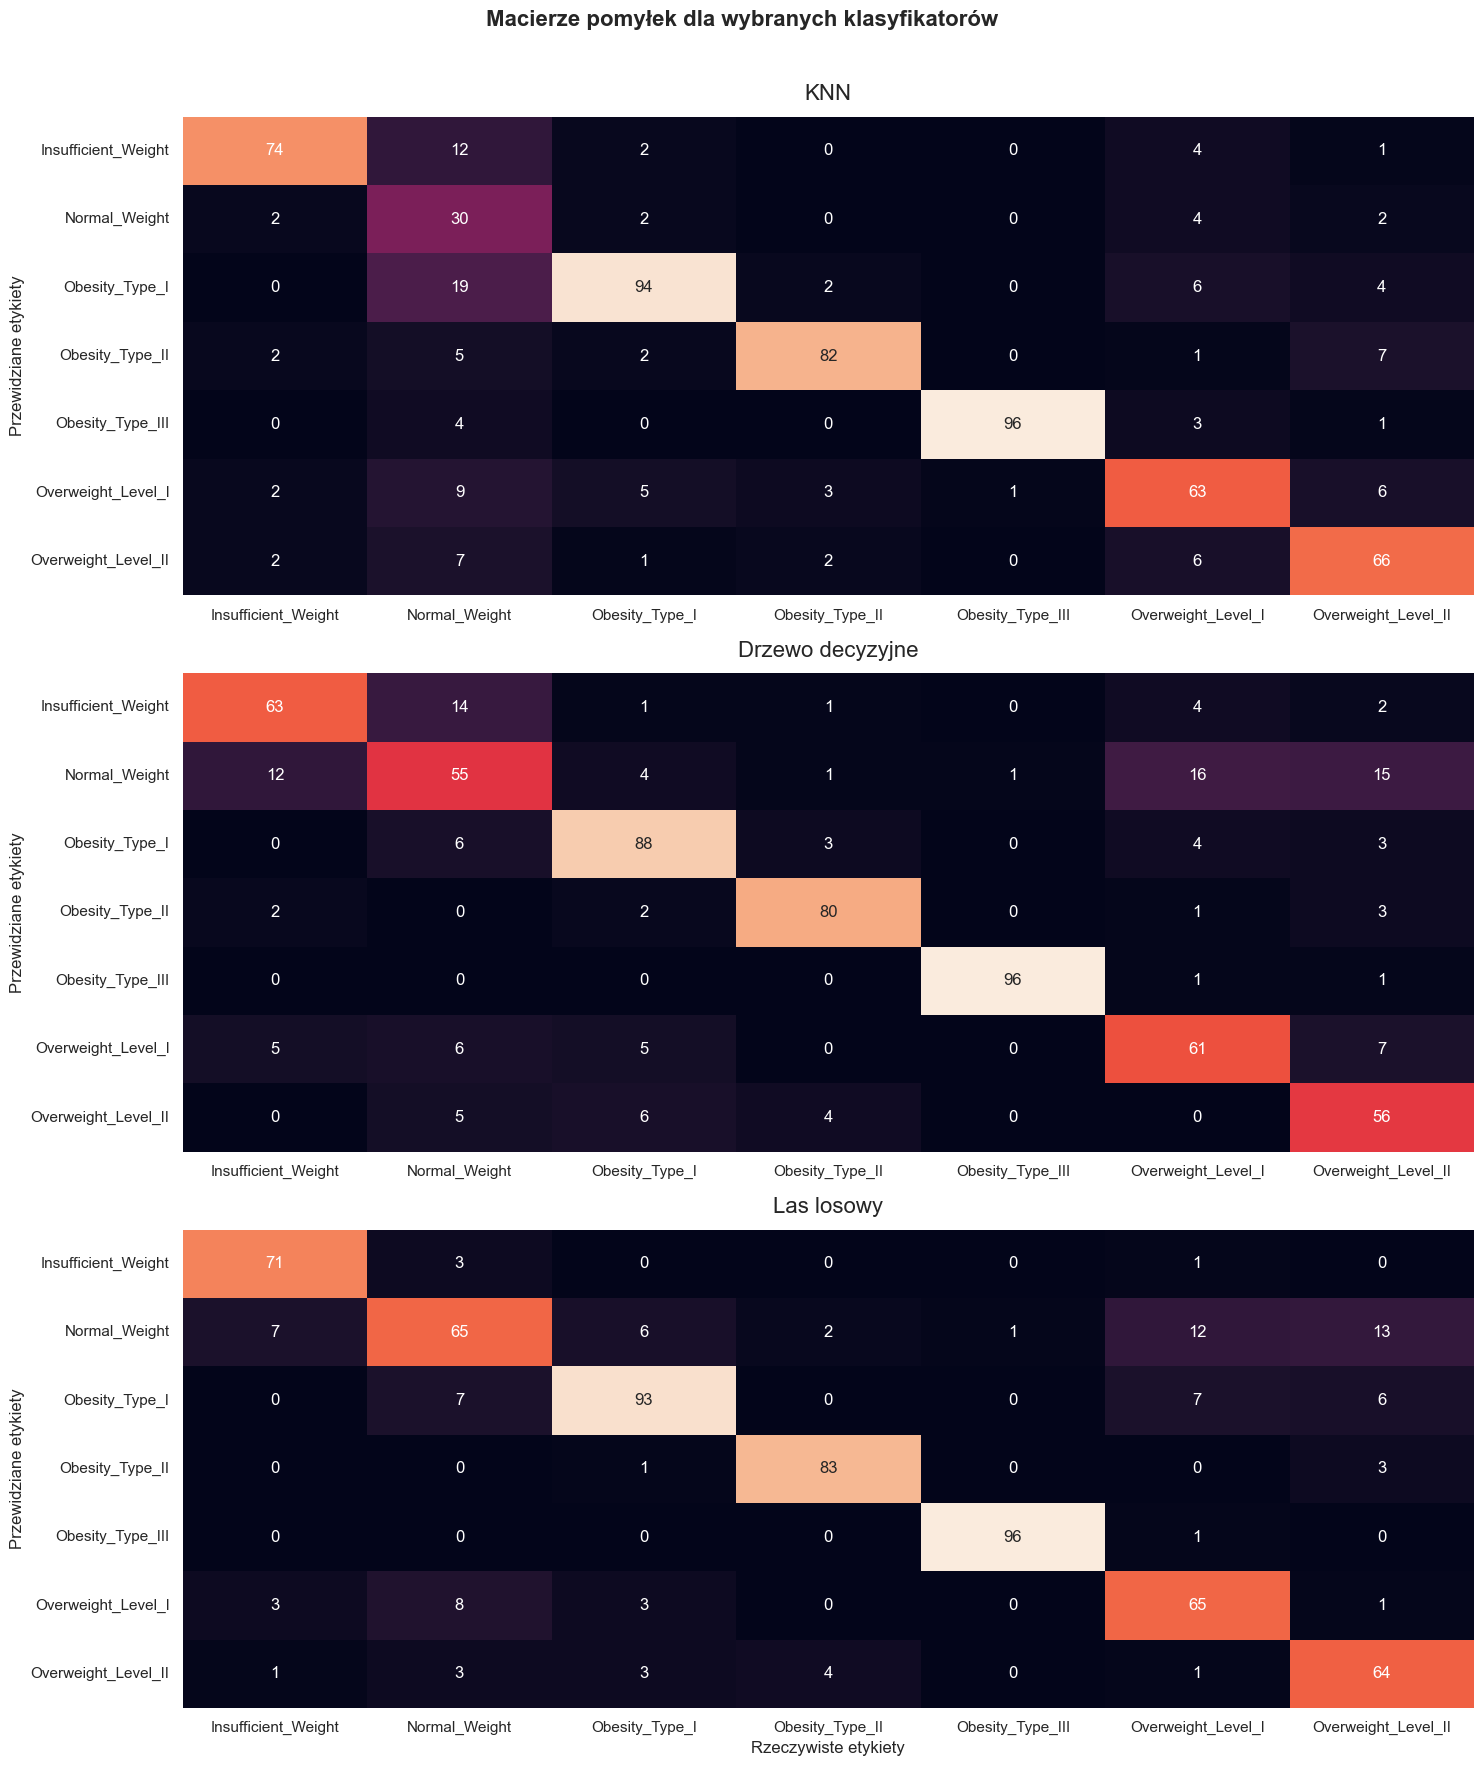

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 18))

fig.suptitle('Macierze pomyłek dla wybranych klasyfikatorów', fontsize=16, fontweight='bold')

pred = [bknn_pred, bdc_pred, brf_pred]
titles = ['KNN', 'Drzewo decyzyjne', 'Las losowy']

sns.set_style('white')

for i in range(3):
    conf_matrix = confusion_matrix(y_test, pred[i])
    sns.heatmap(
        conf_matrix.T,
        annot=True,
        fmt='d',
        cbar=False,
        xticklabels=obesity_encoder.classes_,
        yticklabels=obesity_encoder.classes_,
        ax=ax[i],
        cmap='rocket'
    )
    ax[i].set_title(f'{titles[i]}', fontsize=16, pad=12)
    ax[i].set_xlabel('Rzeczywiste etykiety' if i == 2 else '')
    ax[i].set_ylabel('Przewidziane etykiety')
    ax[i].grid(False)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

#### <center>Krzywe ROC (One-vs-Rest)</center>
Dla problemu klasyfikacji na zbiorze, w którym jest więcej niż 2 klasy, bez przekształcenia klas nie można bezpośrednio wykorzystać krzywych ROC. Istnieją dwa popularne podejścia do adaptacji ROC do problemu wieloklasowego:

- One-vs-Rest (OvR) -> generuje N krzywych ROC, gdzie każda klasa jest traktowana jako pozytywna, a wszystkie pozostałe jako negatywne. To najczęściej stosowana metoda i umożliwia analizę skuteczności klasyfikatora względem każdej klasy osobno.

- One-vs-One (OvO) -> generuje N(N - 1)/2 krzywych ROC, porównując każdą parę klas oddzielnie (np. klasa 1 vs klasa 2, klasa 1 vs klasa 3, itd.). Ten sposób jest bardziej złożony, ale daje dokładniejszy wgląd w rozróżnialność między konkretnymi parami klas.

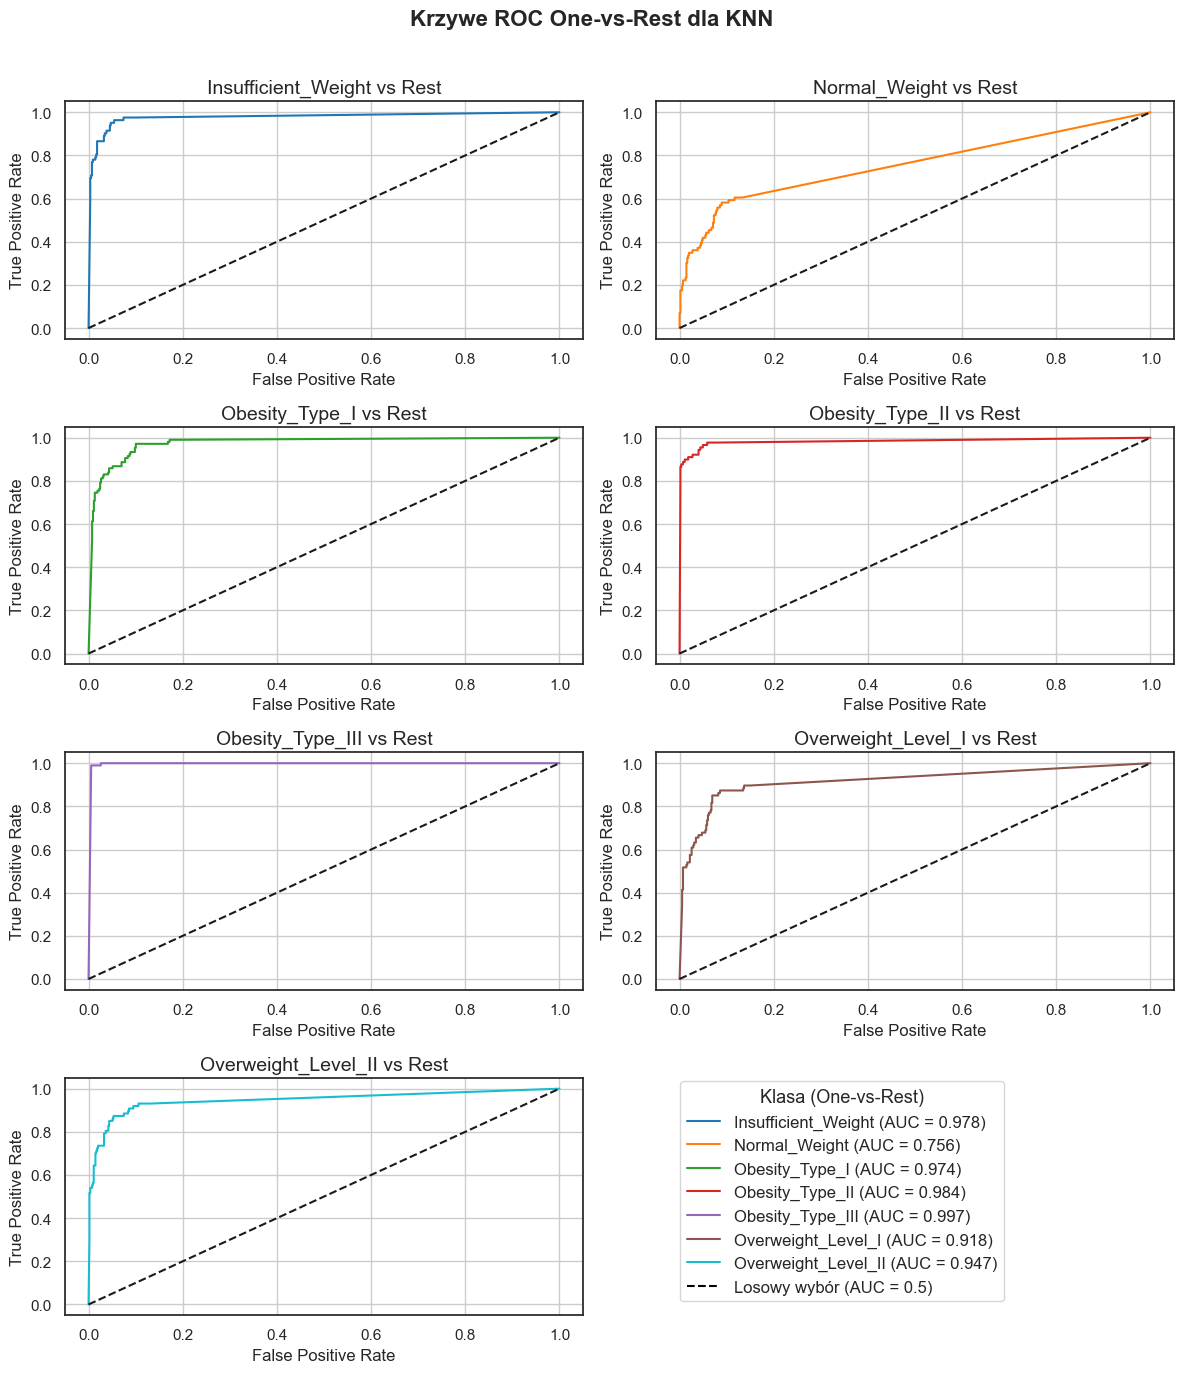

In [21]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

class_of_interest = obesity_encoder.inverse_transform(class_labels)
knn_y_score = knn_pipeline.predict_proba(X_test)

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12, 14))
fig.suptitle('Krzywe ROC One-vs-Rest dla KNN', fontsize=16, fontweight='bold')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#17becf']
knn_auc_scores = [roc_auc_score(y_onehot_test[:, i], knn_y_score[:, i]) for i in range(len(class_labels))]
legend_elements = [Line2D([0], [0], color=colors[i], label=f'{class_of_interest[i]} (AUC = {knn_auc_scores[i]:.3f})') for i in range(len(class_of_interest))]
legend_elements.append(Line2D([0], [0], linestyle='dashed', color='black', label=f'Losowy wybór (AUC = 0.5)'))

for class_id in range(7):
    i, j = divmod(class_id, 2)
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        knn_y_score[:, class_id],
        name=f'{class_of_interest[class_id]} vs Rest',
        plot_chance_level=True,
        ax=ax[i, j],
        color=colors[class_id]
    )
    ax[i, j].grid(True)
    ax[i, j].set_label(class_of_interest[class_id])
    ax[i, j].set_title(f'{class_of_interest[class_id]} vs Rest', fontsize=14)
    ax[i, j].set_xlabel('False Positive Rate')
    ax[i, j].set_ylabel('True Positive Rate')
    ax[i, j].get_legend().remove()

ax[3, 1].axis('off')

fig.legend(
    title='Klasa (One-vs-Rest)',
    handles=legend_elements,
    bbox_to_anchor=(0.85, 0.22),
    ncol=1,
    fontsize=12,
    title_fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

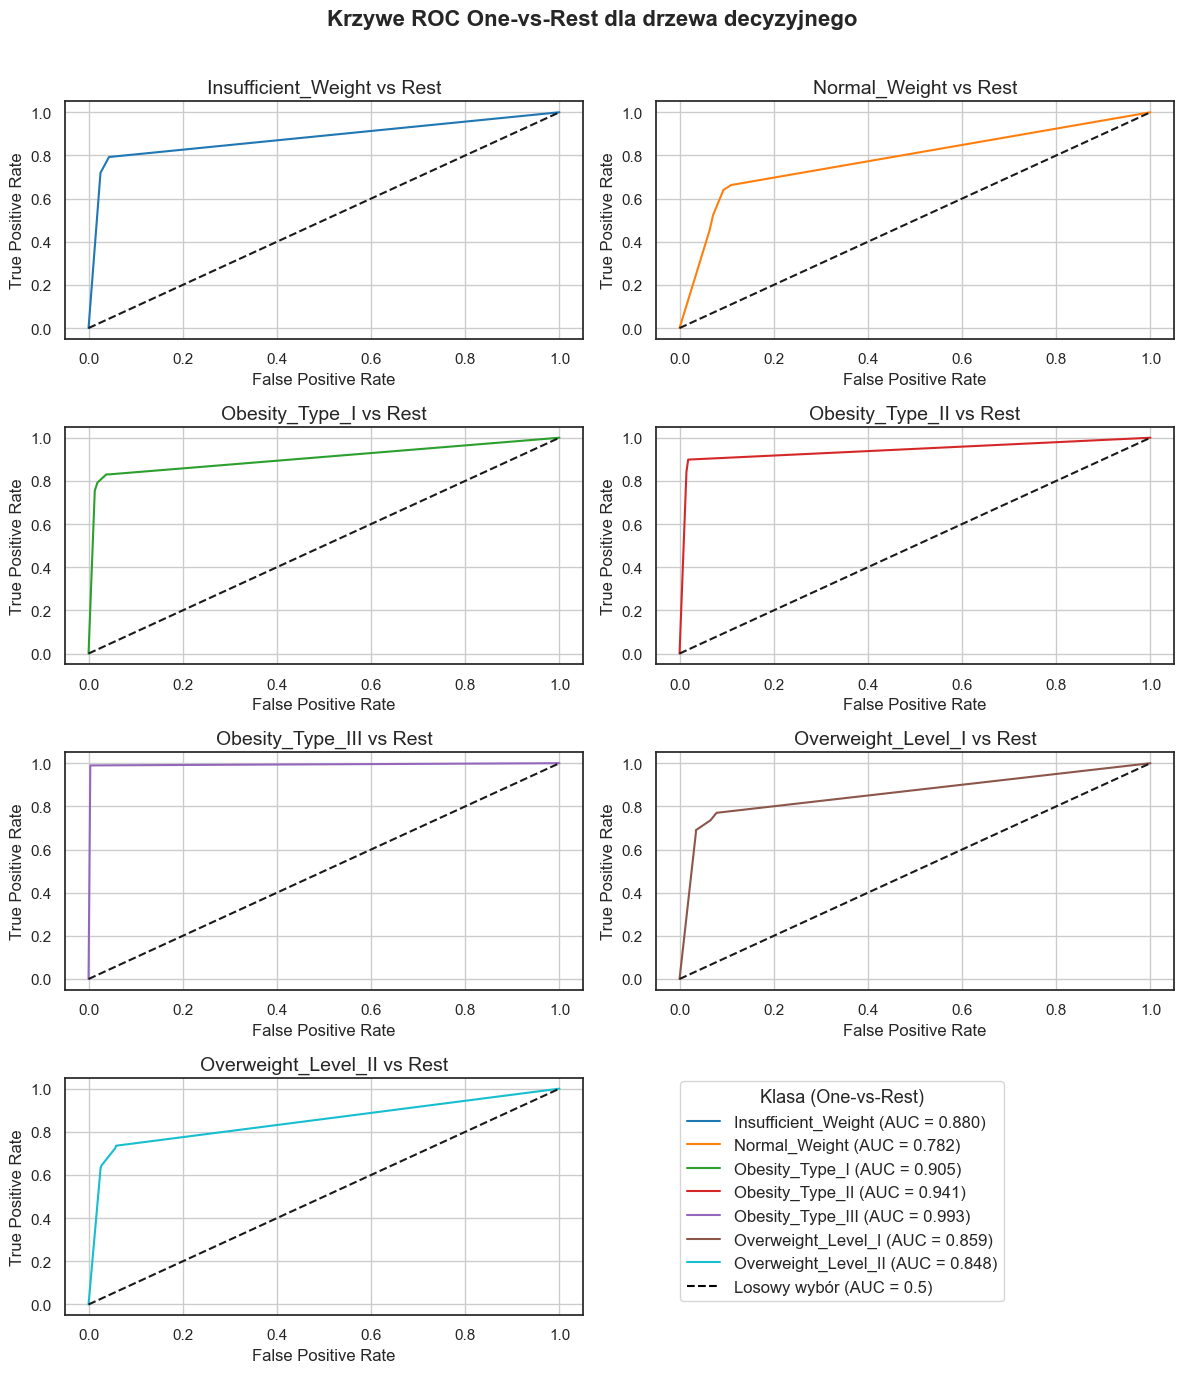

In [22]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

class_of_interest = obesity_encoder.inverse_transform(class_labels)
dc_y_score = bdc.predict_proba(X_test)

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12, 14))
fig.suptitle('Krzywe ROC One-vs-Rest dla drzewa decyzyjnego', fontsize=16, fontweight='bold')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#17becf']
dc_auc_scores = [roc_auc_score(y_onehot_test[:, i], dc_y_score[:, i]) for i in range(len(class_labels))]
legend_elements = [Line2D([0], [0], color=colors[i], label=f'{class_of_interest[i]} (AUC = {dc_auc_scores[i]:.3f})') for i in range(len(class_of_interest))]
legend_elements.append(Line2D([0], [0], linestyle='dashed', color='black', label=f'Losowy wybór (AUC = 0.5)'))

for class_id in range(7):
    i, j = divmod(class_id, 2)
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        dc_y_score[:, class_id],
        name=f'{class_of_interest[class_id]} vs Rest',
        plot_chance_level=True,
        ax=ax[i, j],
        color=colors[class_id]
    )
    ax[i, j].grid(True)
    ax[i, j].set_label(class_of_interest[class_id])
    ax[i, j].set_title(f'{class_of_interest[class_id]} vs Rest', fontsize=14)
    ax[i, j].set_xlabel('False Positive Rate')
    ax[i, j].set_ylabel('True Positive Rate')
    ax[i, j].get_legend().remove()

ax[3, 1].axis('off')

fig.legend(
    title='Klasa (One-vs-Rest)',
    handles=legend_elements,
    bbox_to_anchor=(0.85, 0.22),
    ncol=1,
    fontsize=12,
    title_fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

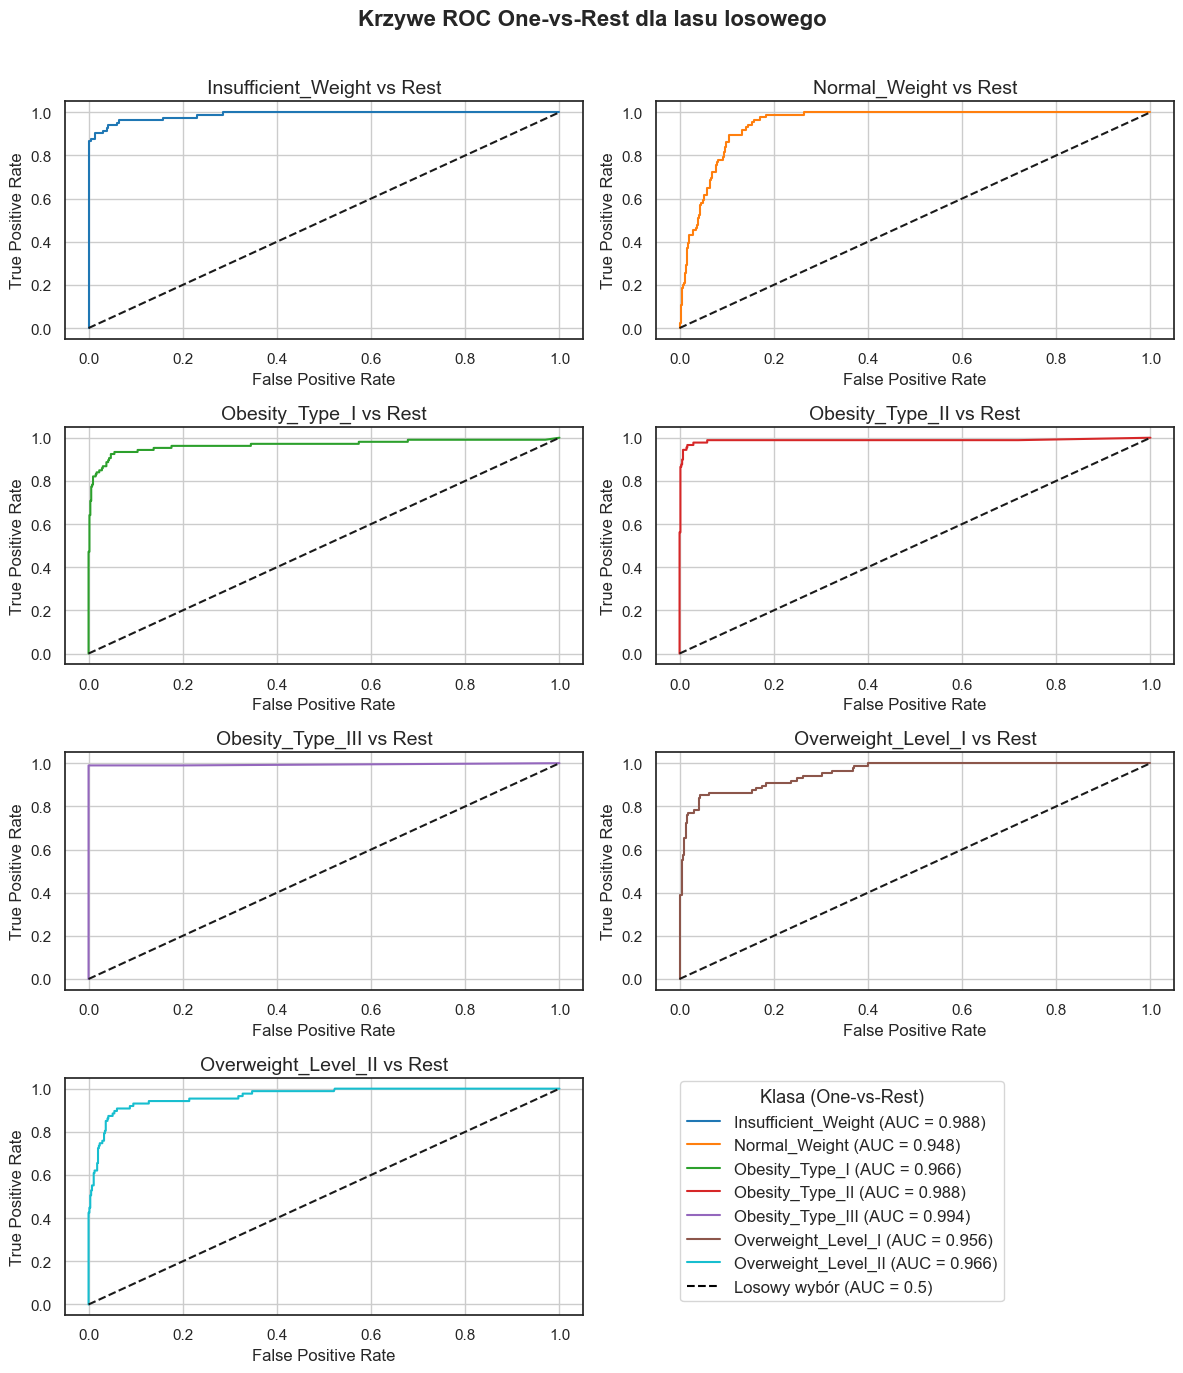

In [23]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

class_of_interest = obesity_encoder.inverse_transform(class_labels)
rf_y_score = brf.predict_proba(X_test)

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12, 14))
fig.suptitle('Krzywe ROC One-vs-Rest dla lasu losowego', fontsize=16, fontweight='bold')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#17becf']
rf_auc_scores = [roc_auc_score(y_onehot_test[:, i], rf_y_score[:, i]) for i in range(len(class_labels))]
legend_elements = [Line2D([0], [0], color=colors[i], label=f'{class_of_interest[i]} (AUC = {rf_auc_scores[i]:.3f})') for i in range(len(class_of_interest))]
legend_elements.append(Line2D([0], [0], linestyle='dashed', color='black', label=f'Losowy wybór (AUC = 0.5)'))

for class_id in range(7):
    i, j = divmod(class_id, 2)
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        rf_y_score[:, class_id],
        name=f'{class_of_interest[class_id]} vs Rest',
        plot_chance_level=True,
        ax=ax[i, j],
        color=colors[class_id]
    )
    ax[i, j].grid(True)
    ax[i, j].set_label(class_of_interest[class_id])
    ax[i, j].set_title(f'{class_of_interest[class_id]} vs Rest', fontsize=14)
    ax[i, j].set_xlabel('False Positive Rate')
    ax[i, j].set_ylabel('True Positive Rate')
    ax[i, j].get_legend().remove()

ax[3, 1].axis('off')

fig.legend(
    title='Klasa (One-vs-Rest)',
    handles=legend_elements,
    bbox_to_anchor=(0.85, 0.22),
    ncol=1,
    fontsize=12,
    title_fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

#### <center>Krzywe uczenia</center>

Wykorzystano StratifiedKFold do wielokrotnego podziału przekazanych zbiorów X, y na zbiory treningowe i walidacyjne, z zachowaniem proporcji klas. Dzięki temu możliwe jest śledzenie, jak zmienia się wydajność modelu (np. dokładność lub strata) w zależności od liczby próbek treningowych. Krzywe uczenia pozwalają ocenić, czy model jest przeuczony (overfitting) lub niedouczony (underfitting).

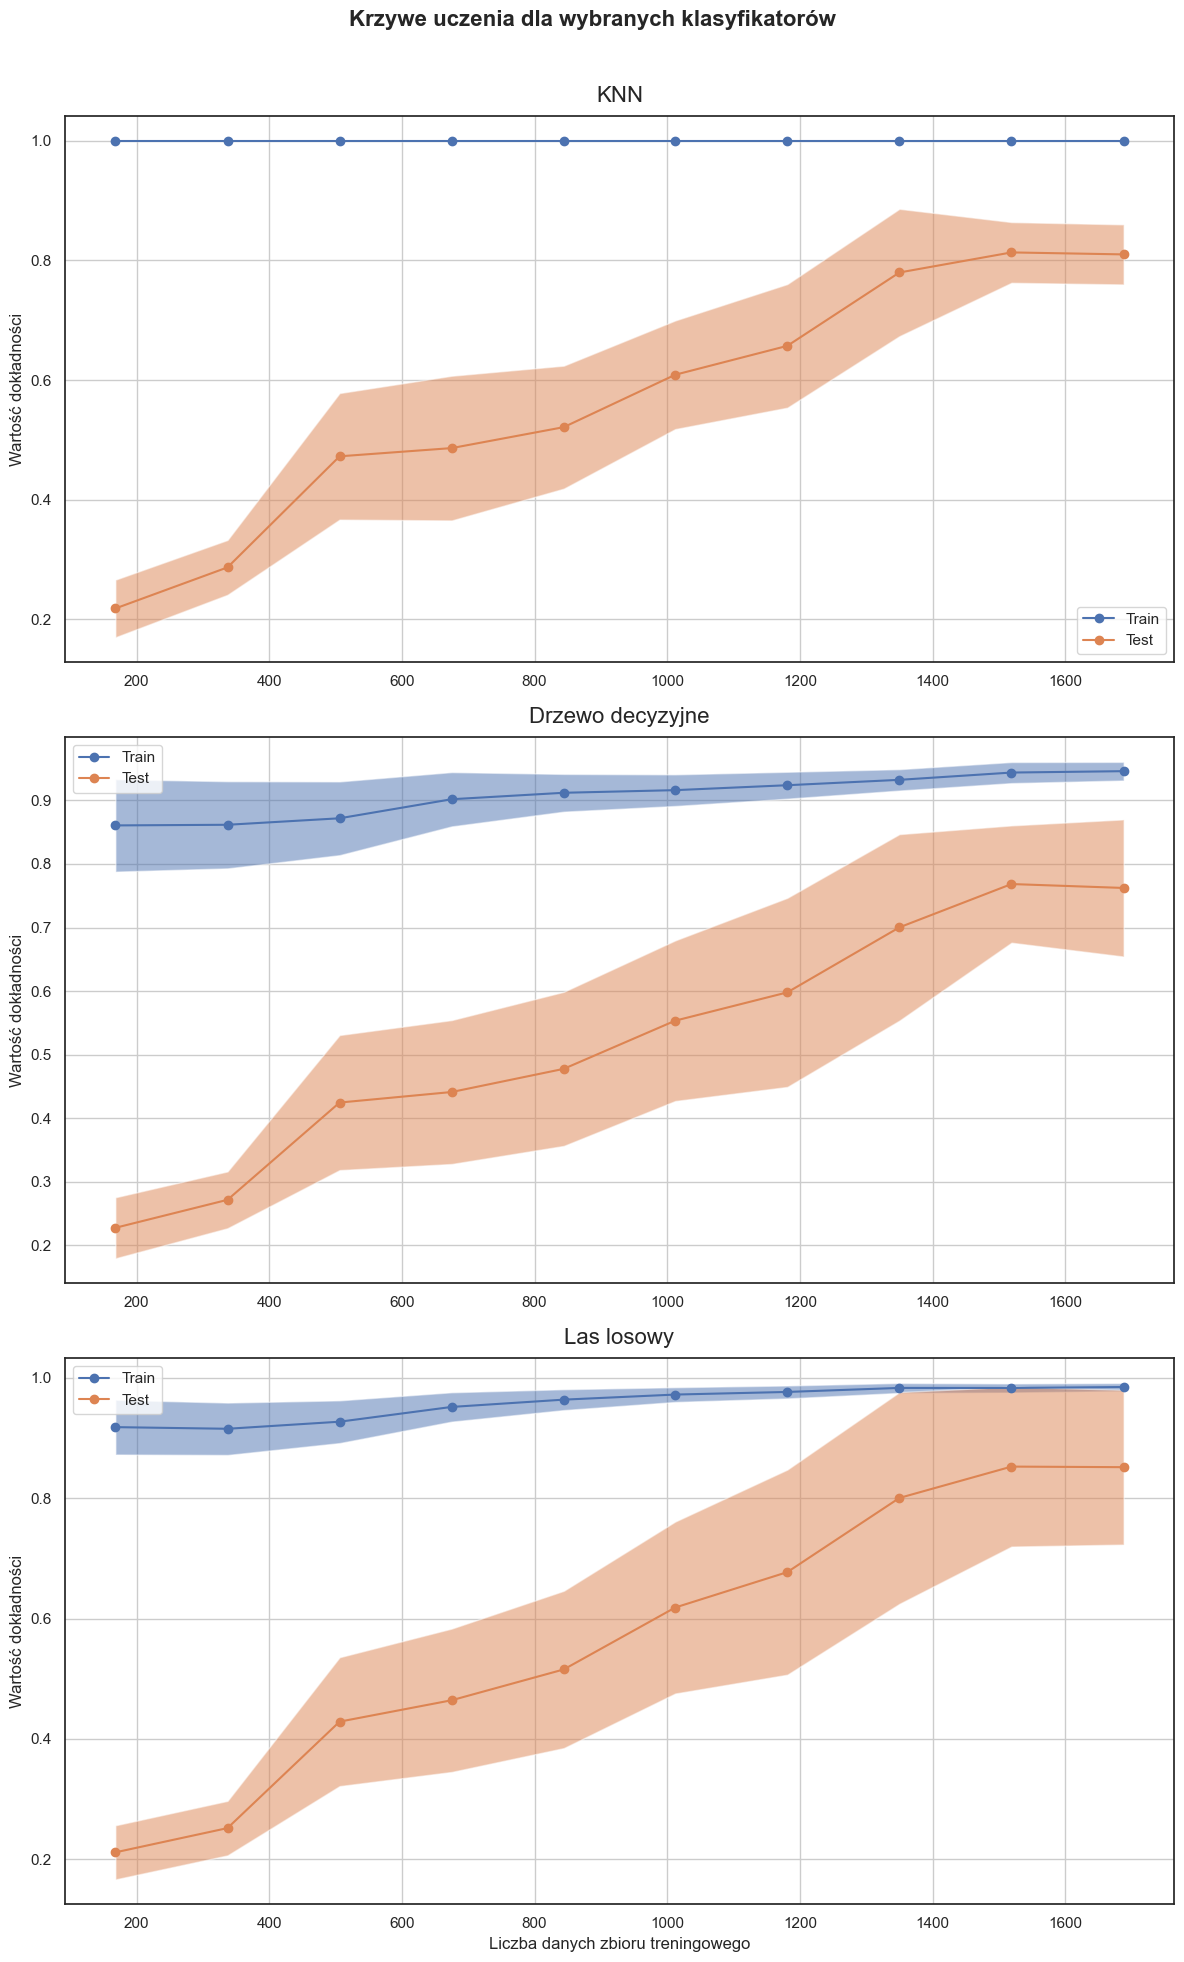

In [24]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 20))

plt.suptitle('Krzywe uczenia dla wybranych klasyfikatorów', fontsize=16, fontweight='bold')
models = [
    knn_pipeline,
    bdc,
    brf
]
titles = ['KNN', 'Drzewo decyzyjne', 'Las losowy']
for i in range(3):
    LearningCurveDisplay.from_estimator(
        estimator=models[i],
        X=X,
        y=y,
        cv=5,
        scoring='accuracy',
        train_sizes=np.linspace(0.1,1.0,10),
        line_kw= {"marker": "o"},
        ax=ax[i],
        n_jobs=-1
    )
    ax[i].grid(True)
    ax[i].set_title(titles[i], fontsize=16, pad=10)
    ax[i].set_ylabel('Wartość dokładności')
    ax[i].set_xlabel('Liczba danych zbioru treningowego' if i == 2 else '')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [25]:
best_knn = study_knn.best_params
best_knn['weights'] = 'uniform'
scaler_only_numeric = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns)
    ],
    remainder='passthrough'
)
knn = Pipeline([('scaler_only_numeric', scaler_only_numeric), ('knn', KNeighborsClassifier(**best_knn))])

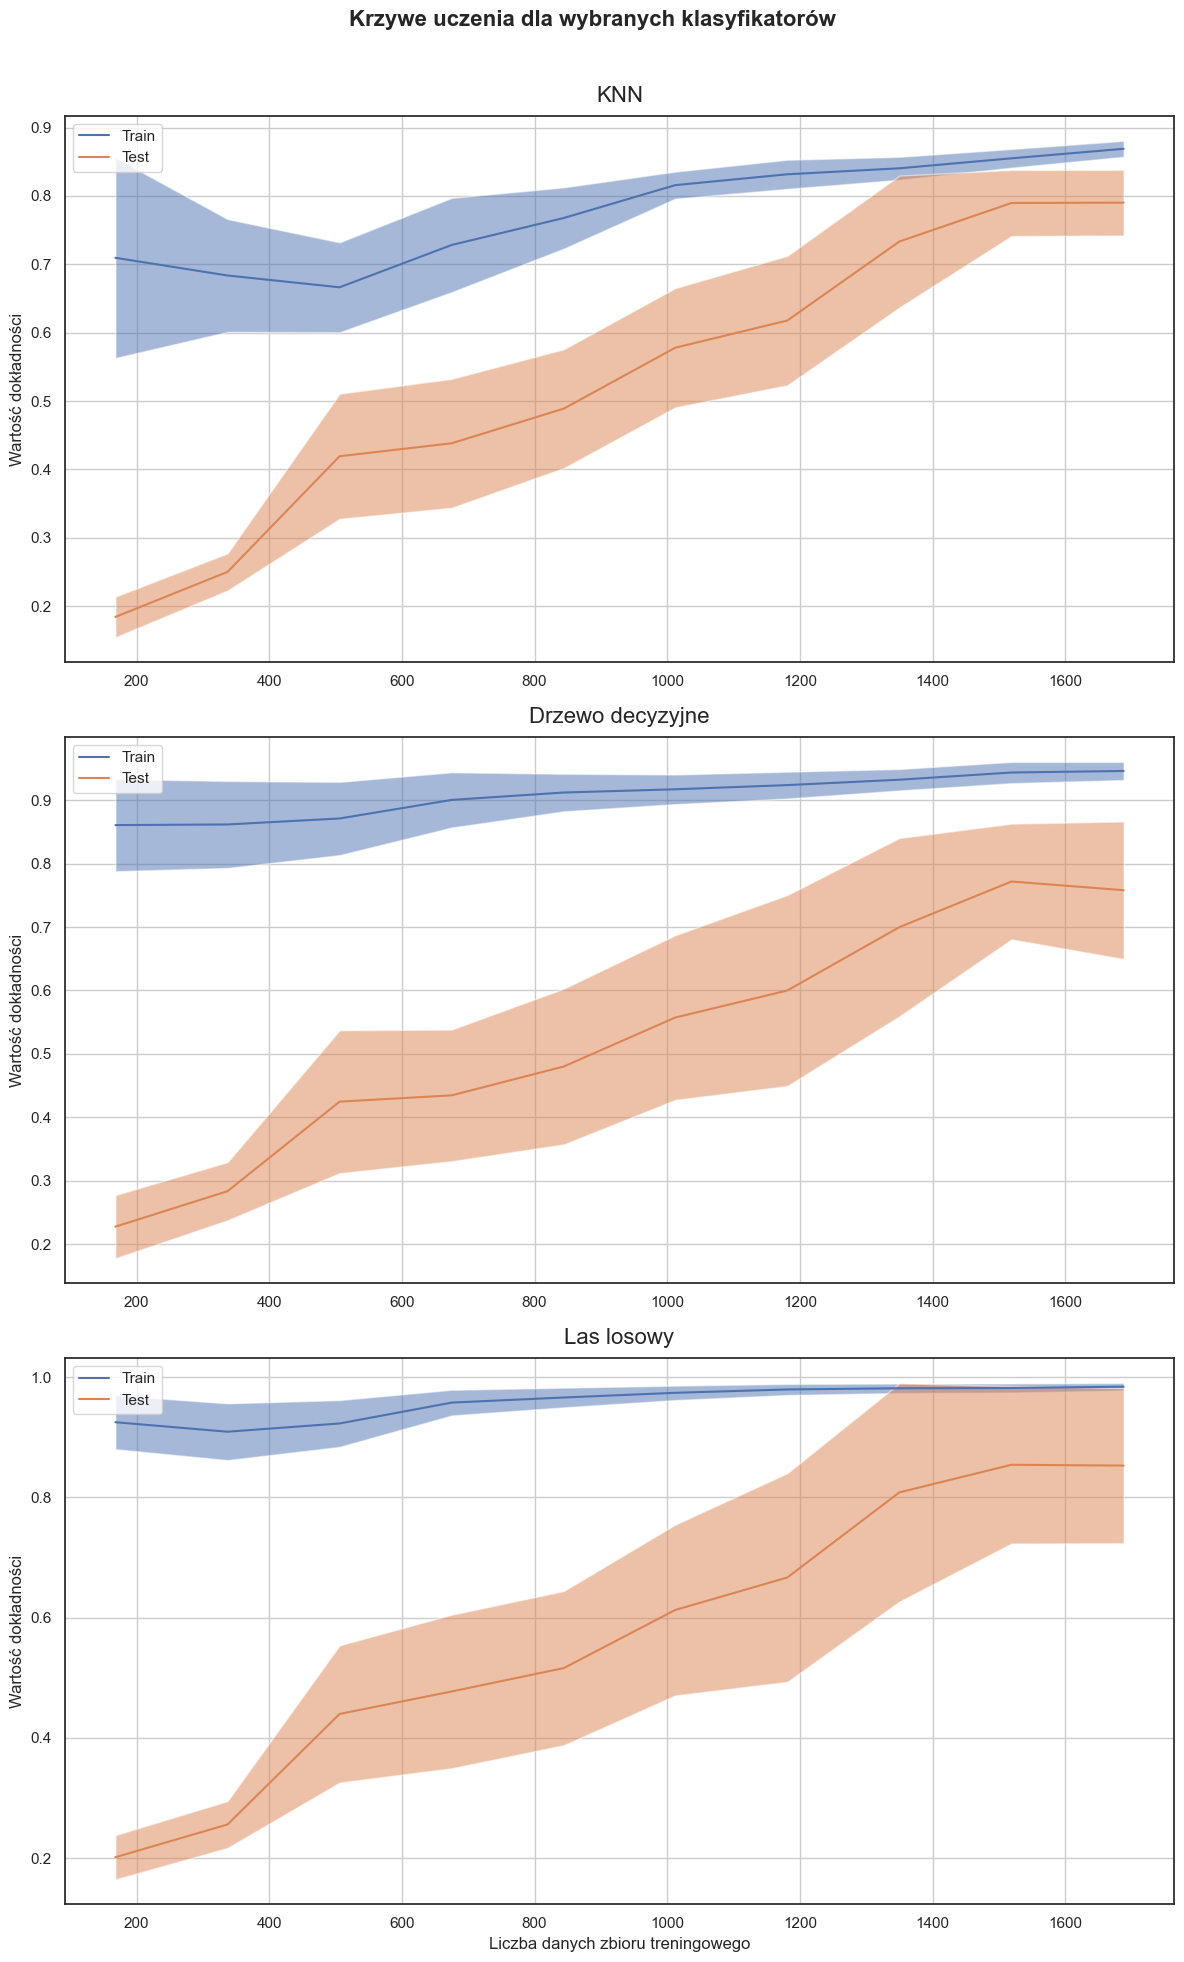

In [26]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 20))

plt.suptitle('Krzywe uczenia dla wybranych klasyfikatorów', fontsize=16, fontweight='bold')
models = [
    knn,
    bdc,
    brf
]
titles = ['KNN', 'Drzewo decyzyjne', 'Las losowy']
for i in range(3):
    LearningCurveDisplay.from_estimator(
        estimator=models[i],
        X=X,
        y=y,
        cv=5,
        scoring='accuracy',
        train_sizes=np.linspace(0.1,1.0,10),
        ax=ax[i],
        n_jobs=-1
    )
    ax[i].grid(True)
    ax[i].set_title(titles[i], fontsize=16, pad=10)
    ax[i].set_ylabel('Wartość dokładności')
    ax[i].set_xlabel('Liczba danych zbioru treningowego' if i == 2 else '')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()